<a href="https://colab.research.google.com/github/RakinduM/AI-weather-forecast/blob/feat%2Ftrain-a-model-using-lstm/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [3]:
### Read Dataset and Exploratory Data Analysis(EDA)
df = pd.read_csv('weatherAUS.csv')
df.head()
df.info()

# Original dataset Shape
# print("Original dataset shape:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

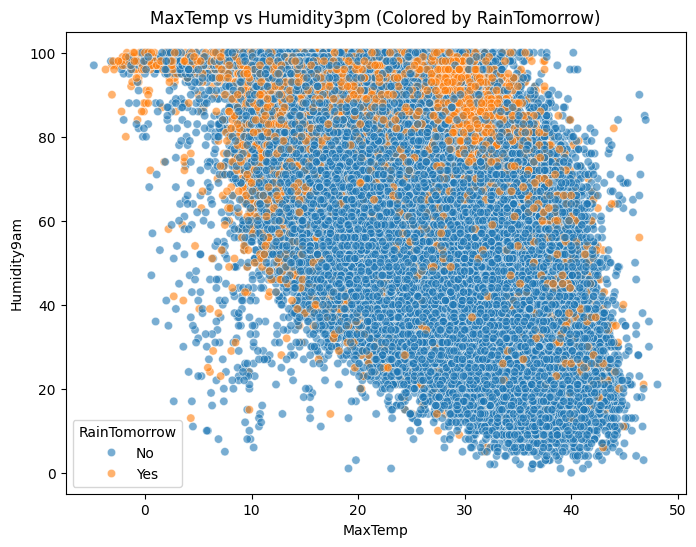

In [4]:
## Visualize Original Dataset

# Scatter plot: MaxTemp vs Humidity3pm colored by RainTomorrow
plt.figure(figsize=(8,6))
sns.scatterplot(x='MaxTemp', y='Humidity9am', hue='RainTomorrow', data=df, alpha=0.6)
plt.title('MaxTemp vs Humidity3pm (Colored by RainTomorrow)')
plt.show()


In [5]:
### 01. Data Preprocessing
# 1. Handle missing values

# fix 1 - Fill missing values before mapping
df['RainToday'] = df['RainToday'].fillna('No')
df['RainTomorrow'] = df['RainTomorrow'].fillna('No')

# 1.1 Drop columns with too many missing values
drop_cols = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']
for col in drop_cols:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

print("Dropped columns:", drop_cols)
print("Remaining columns:", df.columns.tolist())
print("-" * 50)

# 1.2 Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()
# Convert numeric columns to numerical values
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Handling numeric missing values
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Handling categorical missing values
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# 1.3 Remove duplicates
# df.drop_duplicates(inplace=True)

# 1.3 Remove duplicates
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]

print(f"Duplicates removed: {before - after}")
print(f"Remaining rows: {after}")
print(f"Missing values per column (should be 0):\n{df.isnull().sum()}")
print("-" * 50)

Dropped columns: ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']
Remaining columns: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']
--------------------------------------------------
Duplicates removed: 0
Remaining rows: 145460
Missing values per column (should be 0):
Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64
--------------------------------------------------


In [6]:
# 2. Preprocess Date
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract day, month, year
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Drop the original date column
df.drop('Date', axis=1, inplace=True)

print("Added new date columns (Day, Month, Year):")
print(df[['Day', 'Month', 'Year']].head())
print("Remaining columns:", df.columns.tolist())
print("-" * 50)

Added new date columns (Day, Month, Year):
   Day  Month  Year
0    1     12  2008
1    2     12  2008
2    3     12  2008
3    4     12  2008
4    5     12  2008
Remaining columns: ['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Day', 'Month', 'Year']
--------------------------------------------------


In [7]:
# Preprocess Location
# df = pd.get_dummies(df, columns=['Location'], drop_first=True)

In [8]:
# Preprocess categorical columns - One hot Encoding

# Encode Target
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Encode Others
categorical_cols = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# if 'RainTomorrow' in categorical_cols:
#     categorical_cols.remove('RainTomorrow')

print("After one-hot encoding:")
print("New shape:", df.shape)
print("Sample columns:", df.columns[:10].tolist())
print("Remaining columns:", df.columns.tolist())
print("Total number of columns:", len(df.columns))
print("-" * 50)

After one-hot encoding:
New shape: (145460, 113)
Sample columns: ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm']
Remaining columns: ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Day', 'Month', 'Year', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahH

In [10]:
# Preprocess numeric columns - Scaling
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

if 'RainTomorrow' in numeric_cols:
    numeric_cols.remove('RainTomorrow')
if 'RainToday' in numeric_cols:
    numeric_cols.remove('RainToday')

scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# fix 2 - convert all to bool
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(float)

print("Scaled numeric columns (0–1 range):")
print(df[numeric_cols].describe().T[['min','max']])
print("-" * 50)

Scaled numeric columns (0–1 range):
               min  max
MinTemp        0.0  1.0
MaxTemp        0.0  1.0
Rainfall       0.0  1.0
WindGustSpeed  0.0  1.0
WindSpeed9am   0.0  1.0
WindSpeed3pm   0.0  1.0
Humidity9am    0.0  1.0
Humidity3pm    0.0  1.0
Pressure9am    0.0  1.0
Pressure3pm    0.0  1.0
Temp9am        0.0  1.0
Temp3pm        0.0  1.0
Day            0.0  1.0
Month          0.0  1.0
Year           0.0  1.0
--------------------------------------------------


In [9]:
# Sort dataset chronologically (important for sequences)
df.sort_values(by=['Year','Month','Day'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Sorted by Date:")
print(df[['Year', 'Month', 'Day']].head(5))
print(df[['Year', 'Month', 'Day']].tail(5))
print("-" * 50)

Sorted by Date:
   Year  Month  Day
0  2007     11    1
1  2007     11    2
2  2007     11    3
3  2007     11    4
4  2007     11    5
        Year  Month  Day
145455  2017      6   25
145456  2017      6   25
145457  2017      6   25
145458  2017      6   25
145459  2017      6   25
--------------------------------------------------


In [11]:
# Check if all numeric now
print("---->Any object columns left?", df.select_dtypes(include='object').columns.tolist()) #should be false

print("---->Any NaNs left?", df.isnull().any().any())
nan_cols = df.columns[df.isnull().any()].tolist() #should be true

print("Columns with NaNs:", nan_cols)
nan_percent = (df.isnull().sum() / len(df)) * 100
print(nan_percent[nan_percent > 0])

all_numeric = df.dtypes.apply(lambda x: np.issubdtype(x, np.number)).all()
print("---->All columns numeric?", all_numeric)

print("---->Column types:")
for col in df.columns:
    print(f"{col}: {df[col].dtype}")


---->Any object columns left? []
---->Any NaNs left? False
Columns with NaNs: []
Series([], dtype: float64)
---->All columns numeric? True
---->Column types:
MinTemp: float64
MaxTemp: float64
Rainfall: float64
WindGustSpeed: float64
WindSpeed9am: float64
WindSpeed3pm: float64
Humidity9am: float64
Humidity3pm: float64
Pressure9am: float64
Pressure3pm: float64
Temp9am: float64
Temp3pm: float64
RainToday: int64
RainTomorrow: int64
Day: float64
Month: float64
Year: float64
Location_Albany: float64
Location_Albury: float64
Location_AliceSprings: float64
Location_BadgerysCreek: float64
Location_Ballarat: float64
Location_Bendigo: float64
Location_Brisbane: float64
Location_Cairns: float64
Location_Canberra: float64
Location_Cobar: float64
Location_CoffsHarbour: float64
Location_Dartmoor: float64
Location_Darwin: float64
Location_GoldCoast: float64
Location_Hobart: float64
Location_Katherine: float64
Location_Launceston: float64
Location_Melbourne: float64
Location_MelbourneAirport: float64
L

In [13]:
### Split data to Train/Test

split_ratio = 0.8
split_index = int(len(df) * split_ratio)
train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()

print("Train shape:", train_df.shape)
print("Test shape:",test_df.shape)


Train shape: (116368, 113)
Test shape: (29092, 113)


Before balancing:
RainTomorrow
0    113583
1     31877
Name: count, dtype: int64


/tmp/ipython-input-2407099730.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RainTomorrow', data=df, palette=['skyblue','navy'])


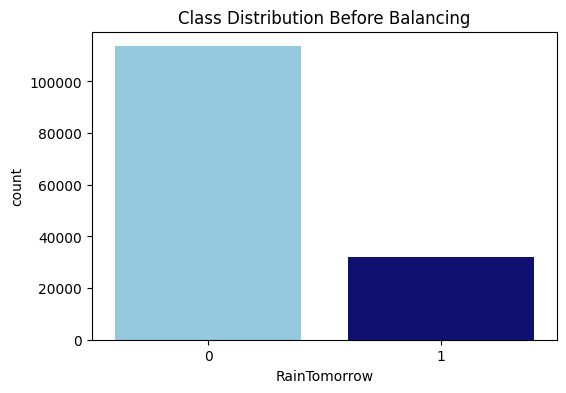

Balanced training class counts:
RainTomorrow
1    90839
0    90839
Name: count, dtype: int64
Before balancing:
RainTomorrow
0    113583
1     31877
Name: count, dtype: int64


/tmp/ipython-input-2407099730.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RainTomorrow', data=train_df, palette=['skyblue','navy'])


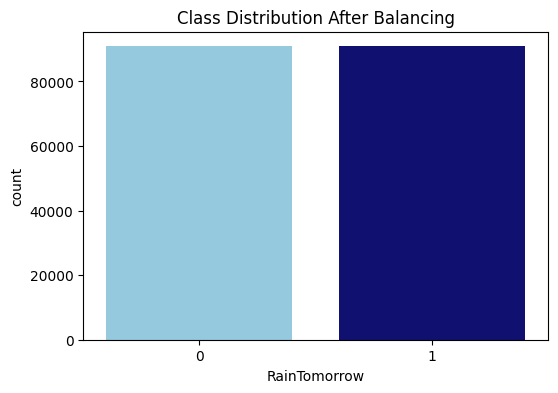

In [15]:
### Class Balancing only Training dataset - Using Oversampling

print("Before balancing:")
print(df['RainTomorrow'].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x='RainTomorrow', data=df, palette=['skyblue','navy'])
plt.title("Class Distribution Before Balancing")
plt.show()

no = train_df[train_df.RainTomorrow == 0]
yes = train_df[train_df.RainTomorrow == 1]
yes_bal = resample(yes, replace=True, n_samples=len(no), random_state=42)
train_df = pd.concat([no, yes_bal]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced training class counts:")
print(train_df['RainTomorrow'].value_counts())

print("Before balancing:")
print(df['RainTomorrow'].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x='RainTomorrow', data=train_df, palette=['skyblue','navy'])
plt.title("Class Distribution After Balancing")
plt.show()

In [17]:
### Create Seqences (Train and Test) with each dataset

def create_sequences(df, seq_len=7):
    X, y = [], []
    data = df.drop('RainTomorrow', axis=1).values
    target = df['RainTomorrow'].values
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(target[i])
    return np.array(X), np.array(y)

seq_len = 7
X_train, y_train = create_sequences(train_df, seq_len)
X_test, y_test = create_sequences(test_df, seq_len)

# Validation split (last 10% of train)
val_size = int(0.1 * len(X_train))
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train = X_train[:-val_size]
y_train = y_train[:-val_size]

print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Val:", X_val.shape)


Train: (163504, 7, 112)
Test: (29085, 7, 112)
Val: (18167, 7, 112)


In [ ]:
### Build LSTM model
model_lstm2 = Sequential()
model_lstm2.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm2.add(Dropout(0.2))
model_lstm2.add(Dense(32, activation='relu'))
model_lstm2.add(Dense(1, activation='sigmoid'))

model_lstm2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_lstm2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        45,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,425 (185.25 KB)

 Trainable params: 47,425 (185.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### Train the model
# from google.colab import drive
# drive.mount('/content/drive')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_lstm2 = model_lstm2.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

# # Save trained LSTM model
# model_lstm.save('rain_prediction_lstm.h5')
# model_lstm.save('/content/drive/MyDrive/rain_prediction_lstm.h5')

Epoch 1/19
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.4992 - loss: 0.6937 - val_accuracy: 0.5010 - val_loss: 0.6931
Epoch 2/19
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.5025 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 3/19
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.5009 - loss: 0.6932 - val_accuracy: 0.4991 - val_loss: 0.6933
Epoch 4/19
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.5034 - loss: 0.6932 - val_accuracy: 0.5017 - val_loss: 0.6932
Epoch 5/19
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.5026 - loss: 0.6931 - val_accuracy: 0.4976 - val_loss: 0.6934
Epoch 6/19
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.5075 - loss: 0.6929 - val_accuracy: 0.4999 - val_loss: 0.6937


In [ ]:
### Evaluate model using test data

# if the accuracy is >70%, model is learning
# is the accuracy is >85%, model is perfect

loss, acc = model_lstm2.evaluate(X_test, y_test)
print("Test Accuracy:", acc)

909/909 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7760 - loss: 0.6924
Test Accuracy: 0.7662712931632996


In [ ]:
## Visualize Traning process and history

# --- Plot Training & Validation Loss ---
plt.subplot(1, 2, 1)
plt.plot(history_lstm2.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_lstm2.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss over Epochs', fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- Plot Training & Validation Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history_lstm2.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_lstm2.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy over Epochs', fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

909/909 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


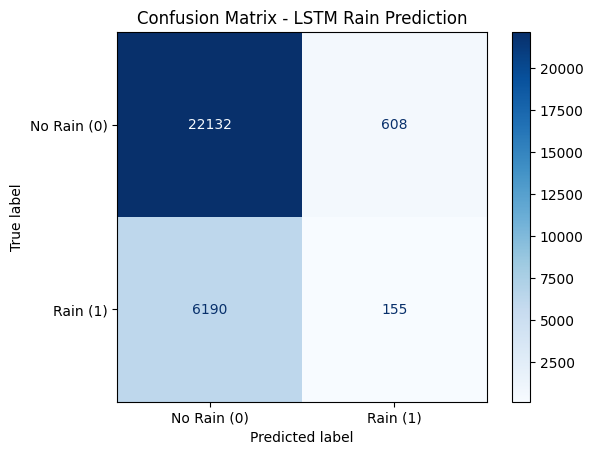


Classification Report:
              precision    recall  f1-score   support

     No Rain       0.78      0.97      0.87     22740
        Rain       0.20      0.02      0.04      6345

    accuracy                           0.77     29085
   macro avg       0.49      0.50      0.46     29085
weighted avg       0.66      0.77      0.69     29085



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Predict
y_pred = model_lstm2.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain (0)', 'Rain (1)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - LSTM Rain Prediction")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['No Rain', 'Rain']))
